In [2]:
import pandas as pd
from transformers import pipeline
import pyLDAvis
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nlp_id.stopword import StopWord
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis.gensim_models as gensimvis
import altair as alt
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nlp_id.tokenizer import Tokenizer
from nltk.corpus import stopwords

# 1. Data Collection

In [3]:
dataset = pd.read_csv("../../Data Collection/Google Reviews/google_reviews_no_index.csv")
reviews = list(dataset["Reviews"])

[reviews[i] for i in range(5)]

['enak banget tempatnya buat adain acara komunitas gitu, bersih, accessible dan luas juga tempatnya. Makasi cakap!',
 'kemarin abis ke cakap, tempatnya cozy dan nyaman banget dipake buat belajar buat meeting buat apapun',
 'Ikut kartu prakerja agak nyesel ngambil kelas di sini, waktu pengumpulan tugasnya ga pasti yang mana. Terbuang sia2 waktu yang saya gunakan☹. Waktu hitung mundur masih ada untuk mengumpul tugas, tetapi sudah tidak bisa. Tidak ada rasa empati kepada siswa dalam membantu menyelesaikan kelas. Pemberian informasi deadline tugas tidak lengkap. Semoga ke depannya waktu hitung mundur dan adminnya sama dalam memberikan waktu deadline tugas akhir.',
 'Tempatnya nyaman bikin betah dan cocok untuk belajar',
 'tempatnya bener bener nyamann bikin pengunjung betah belajar disanaa',
 'Tempat terbaik untuk mengasah kemampuan. Bekerja sambil belajar.',
 '26 kredit hangus tanpa pemberitahuan sebelumnya',
 'Belajarnya nyaman krn jadwal bisa fleksibel, tutor dan materinya mudah dimenge

# 2. Data Preprocessing

In [ ]:
# Remove Indonesian stop words
stopword = StopWord()
stop_removed = [stopword.remove_stopword(text) for text in reviews]

# Preprocess string
processed_docs = [preprocess_string(doc) for doc in stop_removed]

# Create dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Tokenization
tokenizer = Tokenizer()
text = " ".join(stop_removed)
tokens = [tokenizer.tokenize(text.lower())][0]

# 3. Data Analysis

## a. Sentiment Analysis

In [4]:
def analyze_sentiment(text_to_analyze):
    # Specify the model and revision explicitly
    model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"

    # Load the sentiment analysis pipeline with explicit model
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model=model_name,
        tokenizer=model_name
    )

    # Perform sentiment analysis
    sentiment_result = sentiment_analyzer(text_to_analyze)

    return sentiment_result

In [ ]:
sentiments = analyze_sentiment(reviews)

In [6]:
# Preparing dataframe which contains review, label, and score
def get_df(sentences, sentiments):
    sents = {
        'review': sentences,
        'label': [senti['label'].upper() for senti in sentiments],
        'score': [senti['score'] for senti in sentiments]
    }

    df = pd.DataFrame(sents)
    return df

In [7]:
senti_df = get_df(reviews, sentiments)
senti_df.head()

,review,label,score
0,enak banget tempatnya buat adain acara komunit...,POSITIVE,0.998875
1,"kemarin abis ke cakap, tempatnya cozy dan nyam...",POSITIVE,0.997210
2,Ikut kartu prakerja agak nyesel ngambil kelas ...,NEGATIVE,0.998917
3,Tempatnya nyaman bikin betah dan cocok untuk b...,POSITIVE,0.999309
4,tempatnya bener bener nyamann bikin pengunjung...,POSITIVE,0.999395


In [8]:
senti_df.to_csv("../../Data Analysis/Google Reviews/google_reviews_sentiment.csv", index=False)

### 1) sentiments distribution

In [46]:
def pie_chart(result, labels):
    plt.figure(figsize=(8, 8))
    plt.pie(result, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.show()

In [73]:
def show_bar_chart(labels, counts):
    _, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323', '#fac343'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylabel('Frequency')

    plt.show()

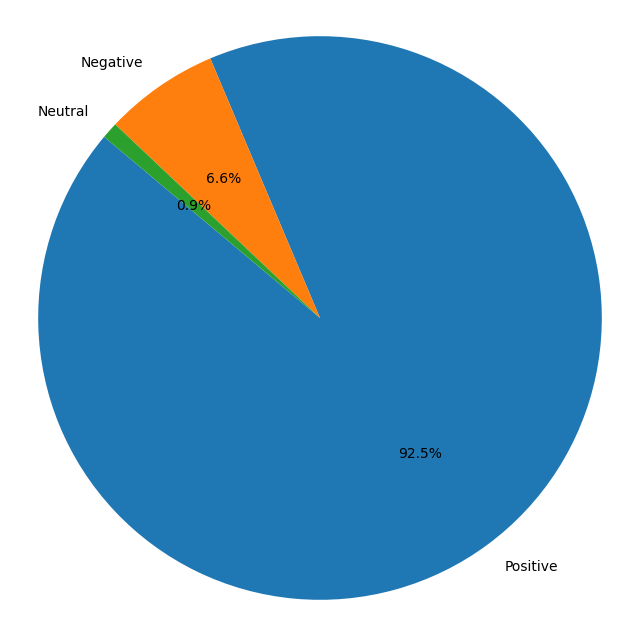

In [74]:
label_count = senti_df['label'].value_counts()
poss = label_count.get('POSITIVE')
negs = label_count.get('NEGATIVE')
neuts = label_count.get("NEUTRAL")

# Given result list and labels
result = [poss, negs, neuts]
labels = ["Positive", "Negative", "Neutral"]

pie_chart(result, labels)

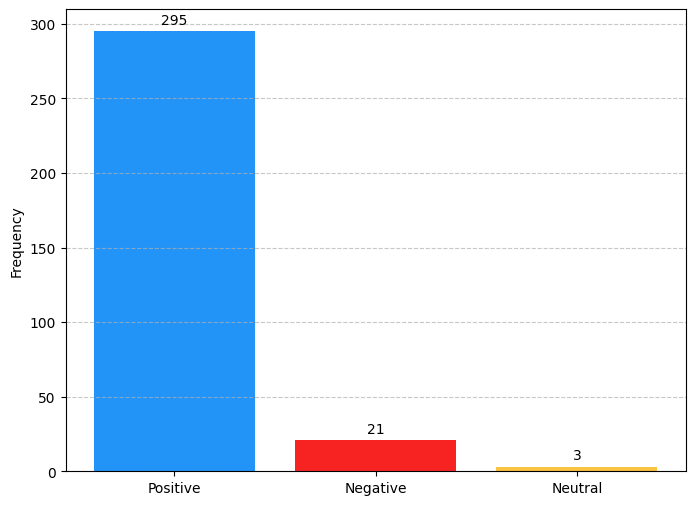

In [75]:
show_bar_chart(
    ["Positive", "Negative", "Neutral"],
    [poss, negs, neuts]
)

### 2) rating prediction

In [14]:
# Removing neutral sentiments because they aren't affecting
# the positivity or negativity
pos_neg_df = senti_df[senti_df["label"] != "NEUTRAL"]
pos_neg_df.head()

,review,label,score
0,enak banget tempatnya buat adain acara komunit...,POSITIVE,0.998875
1,"kemarin abis ke cakap, tempatnya cozy dan nyam...",POSITIVE,0.997210
2,Ikut kartu prakerja agak nyesel ngambil kelas ...,NEGATIVE,0.998917
3,Tempatnya nyaman bikin betah dan cocok untuk b...,POSITIVE,0.999309
4,tempatnya bener bener nyamann bikin pengunjung...,POSITIVE,0.999395
...,...,...,...
314,insightful!!,NEGATIVE,0.910058
315,Bagus,POSITIVE,0.930638
316,good,POSITIVE,0.999060
317,sangat membantu,POSITIVE,0.995917


In [51]:
positivity = senti_df.apply(lambda row: 1 - row['score'] if row['label'] == 'NEGATIVE' else row['score'], axis=1)
normalized_scores = [(score * 4) + 1 for score in (positivity)]

In [55]:
import numpy as np

def hist(normalized_scores):
    bin_width = 0.5
    num_bins = int((max(normalized_scores) - min(normalized_scores)) / bin_width)

    plt.hist(normalized_scores, bins=num_bins, edgecolor='black')
    plt.xlabel('Normalized Scores')
    plt.ylabel('Frequency')
    plt.title(f'Average Rating: {np.mean(normalized_scores):.2f}')
    plt.show()

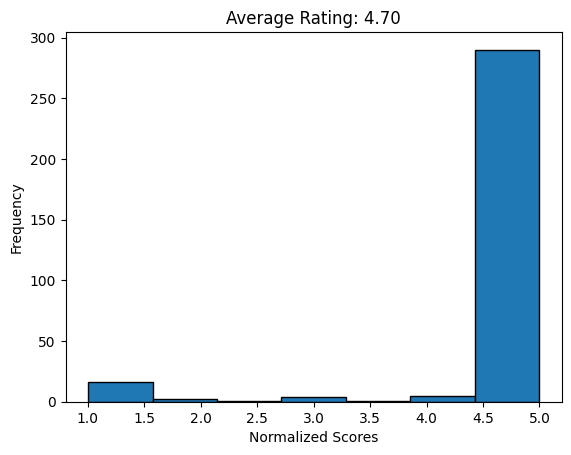

In [56]:
hist(normalized_scores)

## b. Topic Modelling

In [19]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=500)

In [20]:
# Visualize topics
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [21]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.506131298832665


## c. Word Cloud

In [66]:
# 5 most frequent tokens
top_5_tokens = Counter(tokens).most_common(5)
tokens_5 = [token[0] for token in top_5_tokens]
counts_5 = [token[1] for token in top_5_tokens]

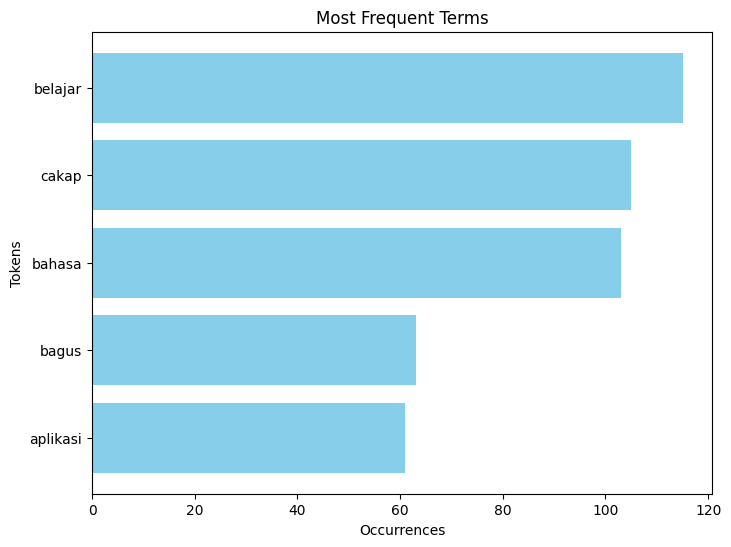

In [67]:
plt.figure(figsize=(8, 6))
plt.barh(tokens_5, counts_5, color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Tokens')
plt.title('Most Frequent Terms')
plt.gca().invert_yaxis()
plt.show()

In [27]:
def generate_wordcloud(words):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(words)

    _, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

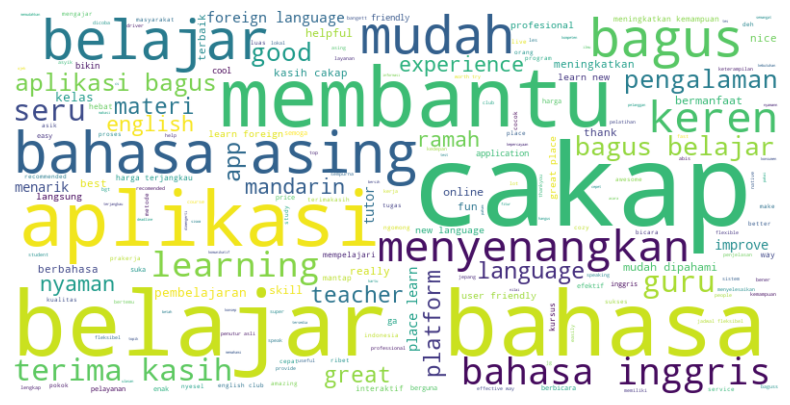

In [76]:
generate_wordcloud(" ".join(tokens))